### Import Relevant Libaries

In [1]:
!pip install emot
!pip install pyLDAvis
!pip install wordcloud
!pip install gensim
!pip install google
from googlesearch import search
import itertools
import csv

import pandas as pd
from datetime import datetime

import os
import emot
import re
import string
import nltk
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from functools import reduce, partial

import gensim
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel

import numpy as np
import tqdm

import requests
from bs4 import BeautifulSoup

import operator

from pprint import pprint

import pyLDAvis.gensim
import pickle 
import pyLDAvis

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


### Text Cleaning Function

In [2]:
def lower_case(text):
    return text.lower()

def remove_stopwords(text):
    """ Remove Stopwords """
    stop_list = stopwords.words('english')
    stop_list += string.punctuation
    stop_list += ['moh','ministry','health','imh','institute','mental','health','hpb','promotion','board','moe','education',
                 'finance','sliver','ribbon','illness','wellness','wellbeing','woodbridge','zealand','year','people','singapore',
                  'person','service','child','life','study','support','cent','time','level','country','help','rate','measure',
                 'community','school','change','system','zealander','use','story','care','programme','disorder','operating','need',
                  'condition','minister','right','population','economy','gdp','resource','issue','problem','fee','cost','impact',
                  'skill','team','approach','development','sector','crown','way','others','relationship','family','hospital','growth','work',
                  'group','access','article','day','tamariki','martin','outcome','information','business','area','report','figure'] #any other stop words
    return [word.strip() for word in text if word.strip() not in stop_list]

def remove_links(text):
    text = re.sub(r'http\S+', '', text) # remove http links
    text = re.sub(r'bit.ly/\S+', '', text) # remove bitly links
    text = re.sub(r'www\S+', '', text) # remove www links
    text = re.sub(r'.*\.com', '', text)
    return text

def remove_symbols(text):
    """ Removes all symbols and keep alphanumerics """
    whitelist = []
    return [re.sub(r'([^a-zA-Z0-9\s]+?)',' ',word) for word in text if word not in whitelist]

def remove_short_words(text,n):
    """ Remove words which are less than or equals to length of n """
    return [word for word in text if len(word) > n]

def remove_apostrophes(text):
    """ Remove words which have 's with a space """
    return [re.sub(r"'s", "",word) for word in text]

def remove_digits(text):
    """ Remove all numbers """
    whitelist = []
    return [re.sub(r'\d+','',word) for word in text if word not in whitelist]

""" Creates a dictionary with slangs and their equivalents and replaces them """
def replaceSlang(text):
    with open('slangs.txt',encoding="ISO-8859-1") as file:
        slang_map = dict(map(str.strip, line.partition('\t')[::2]) for line in file if line.strip())
    return [slang_map[word] if word in slang_map.keys() else word for word in text]

""" Creates a dictionary with contractions and their equivalents and replaces them """
def replaceContraction(text):
    with open('contractions.txt',encoding="ISO-8859-1") as file:
        contraction_map = dict(map(str.strip, line.partition('\t')[::2]) for line in file if line.strip())
    return [contraction_map[word] if word in contraction_map.keys() else word for word in text]

def replaceElongated(word):
    """ Replaces an elongated word with its basic form, unless the word exists in the lexicon """

    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def replace(word, pos=None):
    """ Creates a set of all antonyms for the word and if there is only one antonym, it returns it """
    antonyms = set()
    for syn in wordnet.synsets(word, pos=pos):
        for lemma in syn.lemmas():
            for antonym in lemma.antonyms():
                antonyms.add(antonym.name())
    if len(antonyms) == 1:
        return antonyms.pop()
    else:
        return None

def replaceNegations(text):
    """ Finds "not" and antonym for the next word and if found, replaces not and the next word with the antonym """
    i, l = 0, len(text)
    words = []
    while i < l:
        word = text[i]
        if word == 'not' and i+1 < l:
            ant = replace(text[i+1])
            if ant:
                words.append(ant)
                i += 2
                continue
        words.append(word)
        i += 1
    return words

def remove_multispaces(text):
    """ Replace multiple spaces with only 1 space """
    return [re.sub(r' +', " ",word) for word in text]

def keep_alphanum(text):
    """ Keep Alphanumeric characters """
    return [word for word in text if word.isalnum()]

def remove_duplicates_in_sentence(text):
    """ Remove consecutive words in a sentence"""
    return re.sub(r'\b(\w+)( \1\b)+', r'\1', text)

def normalize_word(text):
    """ Own mapping function """
    replacement_dict = {'worker':'employee','funding':'fund','financing':'fund'}

    text = [replacement_dict[word.strip()] if word.strip() in replacement_dict.keys() else word.strip() for word in text]

    return text

def make_best_bigrams(myString):
    tokens = nltk.word_tokenize(myString)
    stop_bigrams = []
    replace_bigrams = {}
    bigram_finder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
    bigrams = bigram_finder.nbest(nltk.collocations.BigramAssocMeasures.chi_sq, 500)
    bigrams = [' '.join(bigram) for bigram in bigrams]
    bigrams = [bigram for bigram in bigrams if bigram not in stop_bigrams]
    return [replace_bigrams[bigram] if bigram in replace_bigrams.keys() else bigram for bigram in bigrams]

# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('N'):
        return wordnet.NOUN
    else:          
        return None

def lemmatize_words(text):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    # Pos tagging
    nltk_tagged = nltk.pos_tag(text)  

    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
        
    # lemmatizing 
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is not None:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))

    return (lemmatized_sentence)

def clean_text(texts):
    new_texts = [lower_case(str(text)) for text in texts]
    new_texts = [remove_links(text) for text in new_texts]
    new_texts = [removeEmoticons(text) for text in new_texts]
    new_texts = [nltk.word_tokenize(str(text)) for text in new_texts]
    new_texts = [replaceSlang(text) for text in new_texts]
    new_texts = [replaceContraction(text) for text in new_texts]
    new_texts = [normalize_word((text)) for text in new_texts]
    new_texts = [remove_apostrophes((text)) for text in new_texts]
    new_texts = [remove_digits((text)) for text in new_texts]
    new_texts = [remove_symbols((text)) for text in new_texts]
    new_texts = [replaceNegations(text) for text in new_texts]
    new_texts = [keep_alphanum(text) for text in new_texts]
    new_texts = [lemmatize_words(text) for text in new_texts]
    new_texts = [remove_multispaces(text) for text in new_texts]
    new_texts = [remove_short_words(text,2) for text in new_texts]
    new_texts = [normalize_word((text)) for text in new_texts]
    new_texts = [remove_stopwords(text) for text in new_texts]
    new_texts = [' '.join(text) for text in new_texts]
    new_texts = [remove_duplicates_in_sentence(str(text)) for text in new_texts]

    return new_texts

<>:69: DeprecationWarning: invalid escape sequence \)
<>:69: DeprecationWarning: invalid escape sequence \)
<>:69: DeprecationWarning: invalid escape sequence \)
<ipython-input-2-8b2b162a6f6c>:69: DeprecationWarning: invalid escape sequence \)
  text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)


### Generate search keywords & get current date

In [3]:
date = datetime.date(datetime.now())

stakeholders = ['moh','ministry of health','imh','institute of mental health','hpb','health promotion board',
                'moe','ministry of education','mof','ministry of finance','sliver ribbon']
keywords = ['mental wellness','mental illness','mental health','mental well-being']

### Google Query

In [4]:
# urls = []
# stop_url = ['https://www.imh.com.sg/','https://www.moh.gov.sg/']


# for stakeholder in stakeholders:
#     for keyword in keywords:
#         query = stakeholder + " + " + keyword
#         for i in search(query,        # The query you want to run
#                 tld = 'com',  # The top level domain
#                 lang = 'en',  # The language
#                 num = 10,     # Number of results per page
#                 start = 0,    # First result to retrieve
#                 stop = 10,  # Last result to retrieve
#                 pause = 2.0,  # Lapse between HTTP requests
#                ):
#             if i not in urls:
#                 if '.pdf' not in i and i not in stop_url:
#                     urls.append(i)
#                     print(i)

# print(len(urls),"urls retrieved!")

### Retrieve Content

In [5]:
# blog_text = []

# written = False
# for i in range(len(urls)):
#     url = urls[i]
#     try:
#         page = requests.get(url)
#         page_content = page.content
#         soup = BeautifulSoup(page_content, 'html.parser')
#         results_list = soup.find_all('p')
#         text_list = []
#         for result in results_list:
#             text_list.append(result.get_text())
#         final_message = " ".join(str(n) for n in text_list)
#         blog_text.append(final_message)
#         if written == False:
#             with open("raw_text.txt", "w") as txt_file:
#                 txt_file.write(final_message + "\n") # works with any number of elements in a line
#             with open("url.txt", "w") as txt_file:
#                 txt_file.write(url + "\n") # works with any number of elements in a line
#             written = True
#         else:
#             with open("raw_text.txt", "a") as txt_file:
#                 txt_file.write(final_message + "\n") # works with any number of elements in a line
#             with open("url.txt", "a") as txt_file:
#                 txt_file.write(url + "\n") # works with any number of elements in a line
#     except:
#         continue

# print(blog_text)

### Text Pre-Processing

#### Load Raw Text

In [6]:
with open('raw_text.txt') as f:
    blog_text = f.readlines()

#### Clean Text

In [7]:
cleaned_blog_text = clean_text(blog_text)
print(cleaned_blog_text)
written = False
for i in range(len(cleaned_blog_text)):
    text = cleaned_blog_text[i]
    if written == False and text != '' and len(text) > 4:
        with open("clean_text.txt", "w") as txt_file:
            txt_file.write(text + "\n") # works with any number of elements in a line
        written = True
    elif text != '':
        with open("clean_text.txt", "a") as txt_file:
            txt_file.write(text + "\n") # works with any number of elements in a line

['press release forum reply', 'click weng mooi chief division agency cho mingxiu founder campus youth psy lady gentleman afternoon today youth conversation dialogue component struggle example teenage identity transition period job adult stress role parent anyone celebrity demi lovato jason mraz experience depression author harry potter book prevention detection intervention workplace build resilience literacy training educator counsellor youth challenge training manager sign symptom staff distress example chat assessment youth awareness response intervention assessment reach student reach professional counsellor student intervention anger anxiety management intervention part world activity part awareness series singaporean event stay oct university campus psy partner exhibit film fringe activity organiser dialogue resilience world explores challenge today youth experience event youth awareness show relevance step effort singaporean stigma barrier youth attitude belief towards misconcep

### Build Dictionary & additional Text Cleaning

#### Load txt file into array

In [8]:
with open('clean_text.txt') as f:
    cleaned_blog_text = f.readlines()

##### Uni vs Bi vs Tri-grams

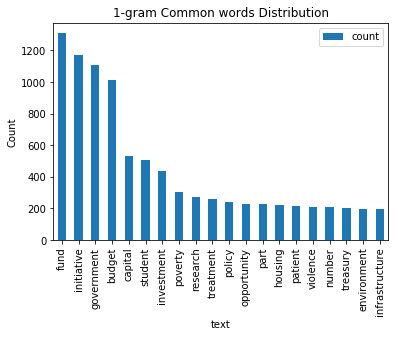

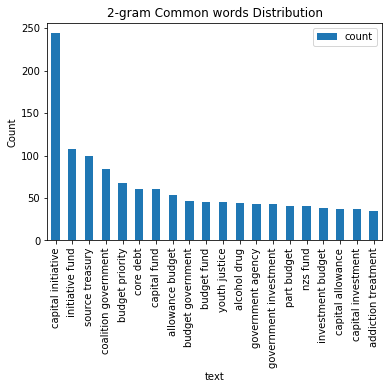

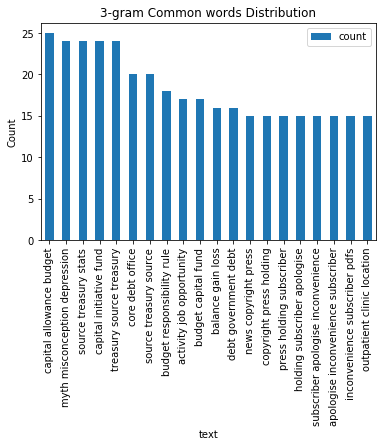

In [9]:
def get_top_n_gram(corpus,a,n=None):
    vec = CountVectorizer(ngram_range=(a,a)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

for i in range(1,4):
    common_words = get_top_n_gram(cleaned_blog_text,i,20)
    df_commonwords = pd.DataFrame(common_words, columns = ['text' , 'count'])

    ax = df_commonwords.plot(
        kind='bar',
        x = 'text',
        y = 'count',
        title=str(i)+'-gram Common words Distribution')
    ax.set_ylabel("Count")
    plt.show()

##### Build Dictionary

In [10]:
texts = [nltk.word_tokenize(text) for text in cleaned_blog_text]
bigrams = [make_best_bigrams(text) for text in cleaned_blog_text]

documents = [texts[i] + bigrams[i] for i in range(len(texts))]

dictionary = gensim.corpora.Dictionary(documents)

# documents = texts

dictionary = gensim.corpora.Dictionary(texts)
print('Unigram Size before filtering:', len(dictionary))
dictionary.filter_extremes(no_below=10)
print('Unigram Size aftering filtering:', len(dictionary))

dictionary.add_documents(bigrams)
print('Total Vocabulary Size before filtering:', len(dictionary))

dictionary.filter_extremes(no_below=10)
print('Total Vocabulary Size after filtering:', len(dictionary), '\n')

corpus = [dictionary.doc2bow(text) for text in documents]
# corpus[0]

Unigram Size before filtering: 4078
Unigram Size aftering filtering: 714
Total Vocabulary Size before filtering: 17712
Total Vocabulary Size after filtering: 789 



### Finding number of topics

In [11]:
##### Can take a long time to run.
limit=6; start=2; step=1;

model_list = []

score = {}
previous_coherence = None
coherence_values = []

for num_topic in range(start, limit, step):
    ldamodel = gensim.models.ldamodel.LdaModel(
                corpus, num_topics = num_topic, id2word=dictionary, passes=10, random_state= 0,
                alpha='auto',eta='auto')
    model_list.append(ldamodel)
    log_perplexity = ldamodel.log_perplexity(corpus)
    perplexity = 2**(-log_perplexity)

    # Compute Coherence Score
    coherencemodel = CoherenceModel(model=ldamodel, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherencemodel.get_coherence()
    if previous_coherence == None:
        score[num_topic] = coherence_lda
        difference = 0
    else:
        difference = coherence_lda-previous_coherence
        score[num_topic] = coherence_lda
    print("Number of topics: {}\nCoherence Value: {}, Difference in Coherence: {}\n".format(num_topic,coherence_lda,difference))
    previous_coherence = coherence_lda
    coherence_values.append(coherence_lda)

Number of topics: 2
Coherence Value: 0.6059687877871017, Difference in Coherence: 0

Number of topics: 3
Coherence Value: 0.6433996600982067, Difference in Coherence: 0.03743087231110498

Number of topics: 4
Coherence Value: 0.6097819128652212, Difference in Coherence: -0.033617747232985495

Number of topics: 5
Coherence Value: 0.5810336886641053, Difference in Coherence: -0.02874822420111589



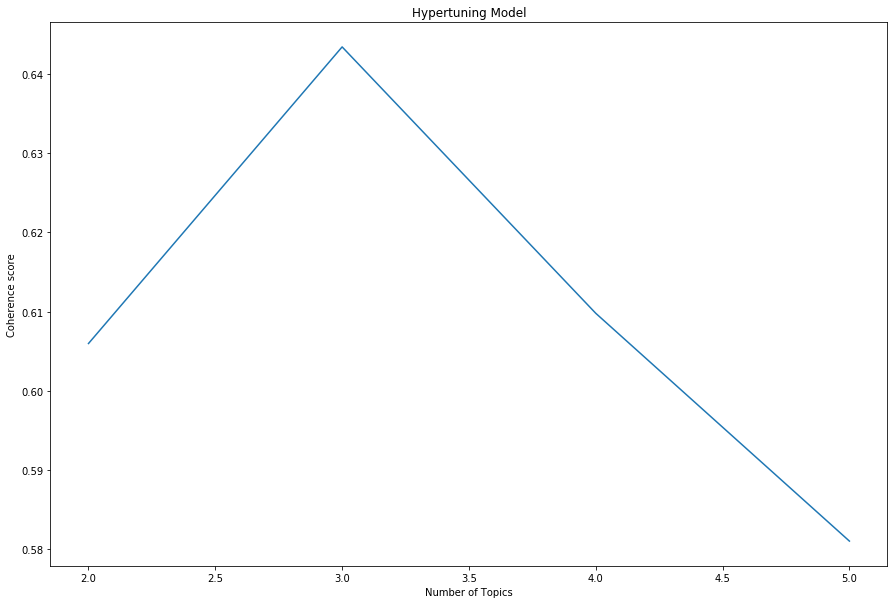

In [12]:
# Show graph
x = range(len(model_list))
plt.figure(figsize=(15, 10))
plt.plot(list(score.keys()), coherence_values)
plt.title("Hypertuning Model")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.savefig('hypertune_chart.png')
plt.show()

In [13]:
index = 0
topics_words = []
for num_topic, scores in score.items():
    print("Number of topics: {}\n Coherence Value: {}".format(num_topic,scores))
    for num ,topic in model_list[index].show_topics(formatted=True, num_topics=num_topic, num_words=10):
        print(str(num)+": "+ topic)
    for num ,topic in model_list[index].show_topics(formatted=False, num_topics=num_topic, num_words=10):
        topic_words = [word[0] for word in topic]
        topics_words += topic_words
    index += 1
    print()

unique_words = set(topic_words)
word_count = {}
for word in unique_words:
    word_count[word] = topics_words.count(word)
print("\nTop Word Counts")
print(sorted(word_count.items(), key=lambda item: item[1], reverse=True))

Number of topics: 2
 Coherence Value: 0.6059687877871017
0: 0.045*"fund" + 0.042*"initiative" + 0.039*"government" + 0.036*"budget" + 0.019*"capital" + 0.016*"investment" + 0.011*"poverty" + 0.008*"policy" + 0.008*"violence" + 0.007*"housing"
1: 0.024*"student" + 0.015*"treatment" + 0.013*"patient" + 0.010*"depression" + 0.009*"research" + 0.008*"psychiatry" + 0.007*"awareness" + 0.007*"healthcare" + 0.007*"addiction" + 0.007*"stress"

Number of topics: 3
 Coherence Value: 0.6433996600982067
0: 0.043*"budget" + 0.028*"poverty" + 0.024*"government" + 0.015*"income" + 0.015*"housing" + 0.013*"priority" + 0.011*"policy" + 0.011*"violence" + 0.011*"evidence" + 0.010*"environment"
1: 0.028*"student" + 0.017*"treatment" + 0.015*"patient" + 0.012*"depression" + 0.009*"psychiatry" + 0.009*"awareness" + 0.008*"healthcare" + 0.008*"research" + 0.007*"dementia" + 0.007*"teacher"
2: 0.061*"fund" + 0.054*"initiative" + 0.042*"government" + 0.029*"budget" + 0.024*"capital" + 0.018*"investment" + 0.0

### Select best number of topics & train final LDA Model

In [14]:
best_model = max(enumerate(coherence_values), key=operator.itemgetter(1))
index = best_model[0]

optimal_model = model_list[index]
optimal_model.save('best_lda_after_filtering.model')

In [15]:
# # later on, load trained model from file
optimal_model =  gensim.models.LdaModel.load('best_lda_after_filtering.model')

doc_lda = optimal_model[corpus]


print(doc_lda)

### Assignment of Topic

In [17]:
topic_composition = {0:"Government's Policy",1:"Raising Mental Wellness Awareness among Schools and Healthcare",2:"Government's Investment/Budget for Mental Wellness Infrastructure or Initiative"}
topics = []
count = 0

with open('results.txt', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Cleaned_Doc", "Topic"])

for results in doc_lda:
    max_score = 0
    topic = 0
    for result in results:
        if result[1] > max_score:
            max_score = result[1]
            topic = result[0]
#     topics.append(topic_composition[topic])
    topics.append(topic_composition[topic])

written = False
for i in range(len(cleaned_blog_text)):
    text = cleaned_blog_text[i]
    if written == False:
        with open("results.txt", "w") as txt_file:
            txt_file.write(text + "\t"+ topics[i]+"\n") # works with any number of elements in a line
        written = True
    elif text != '':
        with open("results.txt", "a") as txt_file:
            txt_file.write(text + "\t"+ topics[i]+"\n") # works with any number of elements in a line

### Visualize using Pyladavis

In [18]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim.prepare(optimal_model, corpus, dictionary)
pyLDAvis.save_html(p, 'index.html')